In [2]:
# 导入基础库

import numpy as np 
from numpy.random import RandomState
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

tf.__version__

'2.3.0'

In [3]:
# 下载测试数据
# 数据源：https://www.openml.org/d/40945
!wget https://www.openml.org/data/get_csv/16826755/phpMYEkMl -O ./titanic.csv

--2020-10-05 11:10:49--  https://www.openml.org/data/get_csv/16826755/phpMYEkMl
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘./titanic.csv’

./titanic.csv           [  <=>               ] 114.98K   374KB/s    in 0.3s    

2020-10-05 11:10:50 (374 KB/s) - ‘./titanic.csv’ saved [117743]



In [48]:
# 查看测试数据
df = pd.read_csv('./titanic.csv')

df = df.replace({'?':np.nan})
df = df.fillna(0)
df['age'] = df['age'].astype("float32")

rng = RandomState()
dftrain_raw = df.sample(frac=0.9, random_state=rng)
dftest_raw = df.loc[~df.index.isin(dftrain_raw.index)]

# Titanic 数据集的目标是根据乘客信息预测他们在 Titanic 号撞击冰山沉没后能否生存。
print('dftrain_raw.shape', dftrain_raw.shape)
print('dftest_raw.shape', dftest_raw.shape)

# 结构化数据一般会使用 Pandas 中的 DataFrame 进行预处理。
dftrain_raw.head(5)

dftrain_raw.shape (1178, 14)
dftest_raw.shape (131, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
460,2,1,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27,0,S,12,0,London
775,3,0,"Doharr, Mr. Tannous",male,0.0,0,0,2686,7.2292,0,C,0,0,0
239,1,0,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,0,0,"Trenton, NJ"
443,2,0,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5,0,S,0,256,"West Hampstead, London / Neepawa, MB"
54,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120,B96 B98,S,4,0,"Bryn Mawr, PA"


字段说明：

- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析 EDA（Exploratory Data Analysis）。



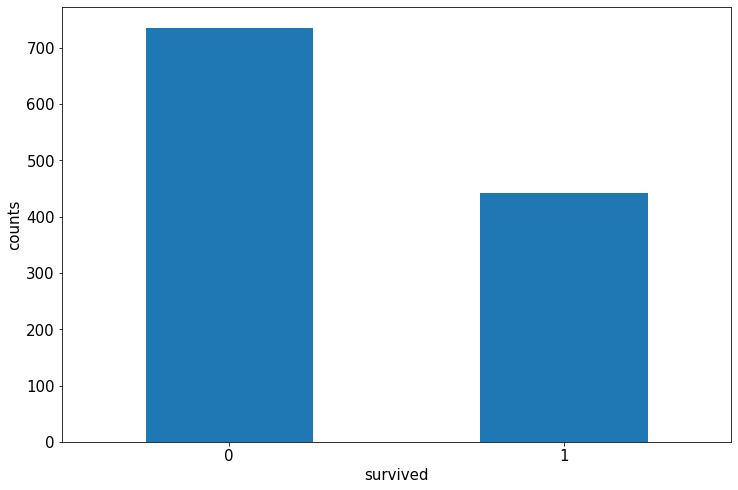

In [49]:
# label 分布情况
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('counts',fontsize = 15)
ax.set_xlabel('survived',fontsize = 15)
plt.show()

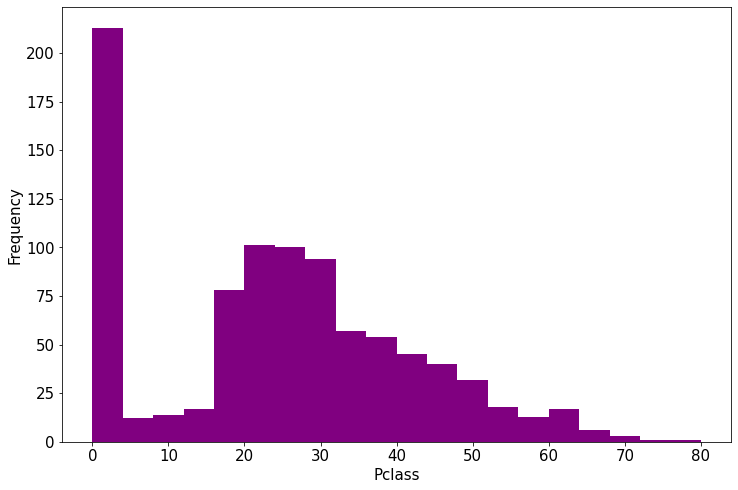

In [90]:
# age 分布情况

%matplotlib inline
%config InlineBackend.figure_format = 'png'

ax = dftrain_raw['age'].plot(kind = 'hist',bins = 20,color = 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Pclass',fontsize = 15)
plt.show()

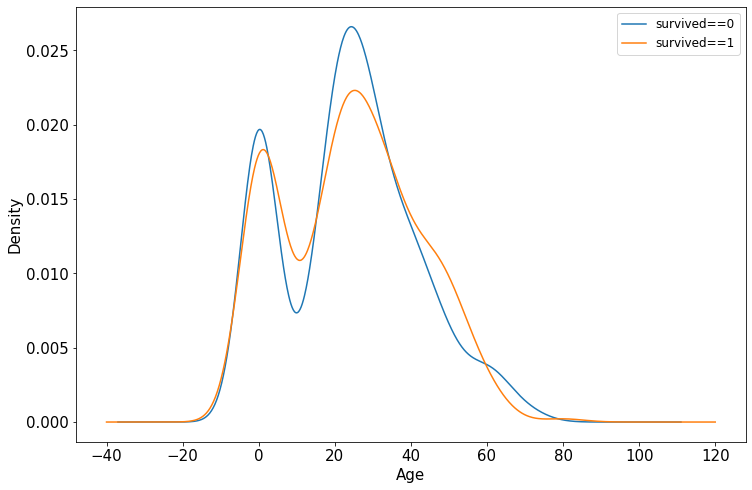

In [91]:
# age 和 label 的相关性

%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('survived == 0')['age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('survived == 1')['age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['survived==0','survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()


In [50]:
# 数据预处理
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    # Pclass
    dfPclass = pd.get_dummies(dfdata['pclass']).astype("float32")
    dfPclass.columns = ['pclass_' + str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass], axis = 1)

    # Sex
    dfSex = pd.get_dummies(dfdata['sex']).astype("float32")
    dfresult = pd.concat([dfresult,dfSex], axis = 1)

    # Age
    dfresult['age'] = dfdata['age'].fillna(0)
    # dfresult['age_null'] = pd.isna(dfdata['age']).astype('float32')

    #SibSp,Parch,Fare
    dfresult['sibsp'] = dfdata['sibsp'].astype('float32')
    dfresult['parch'] = dfdata['parch'].astype('float32')
    dfresult['fare'] = dfdata['fare'].astype('float32')

    # Carbin
    # dfresult['cabin_null'] =  pd.isna(dfdata['cabin']).astype('float32')

    # Embarked
    dfEmbarked = pd.get_dummies(dfdata['embarked'], dummy_na=True).astype("float32")

    dfEmbarked.columns = ['embarked_' + str(x) for x in dfEmbarked.columns]
    if 'embarked_0' in dfEmbarked:
      del dfEmbarked['embarked_0']
      
    dfresult = pd.concat([dfresult, dfEmbarked], axis = 1)  

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.head(5)

x_train.shape = (1178, 13)
x_test.shape = (131, 13)


,pclass_1,pclass_2,pclass_3,female,male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,embarked_nan
460,0.0,1.0,0.0,1.0,0.0,24.0,2.0,1.0,27.0000,0.0,0.0,1.0,0.0
775,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.2292,1.0,0.0,0.0,0.0
239,1.0,0.0,0.0,0.0,1.0,31.0,0.0,0.0,50.4958,0.0,0.0,1.0,0.0
443,0.0,1.0,0.0,0.0,1.0,32.0,2.0,0.0,73.5000,0.0,0.0,1.0,0.0
54,1.0,0.0,0.0,0.0,1.0,11.0,1.0,2.0,120.0000,0.0,0.0,1.0,0.0


In [26]:
x_test.head(5)

,pclass_1,pclass_2,pclass_3,female,male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S,embarked_nan
4,1.0,0.0,0.0,1.0,0.0,25.0,1.0,2.0,151.550003,0.0,0.0,1.0,0.0
17,1.0,0.0,0.0,1.0,0.0,50.0,0.0,1.0,247.520798,1.0,0.0,0.0,0.0
62,1.0,0.0,0.0,0.0,1.0,46.0,1.0,0.0,61.174999,0.0,0.0,1.0,0.0
79,1.0,0.0,0.0,1.0,0.0,55.0,2.0,0.0,25.700001,0.0,0.0,1.0,0.0
88,1.0,0.0,0.0,1.0,0.0,33.0,0.0,0.0,151.550003,0.0,0.0,1.0,0.0


# 定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。此处选择使用最简单的Sequential，按层顺序模型。

In [51]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(13,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


# 训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。



In [52]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )


Epoch 1/30
15/15 [==============================] - 0s 23ms/step - loss: 0.6459 - auc: 0.6449 - val_loss: 0.6001 - val_auc: 0.6717
Epoch 2/30
15/15 [==============================] - 0s 3ms/step - loss: 0.6245 - auc: 0.6622 - val_loss: 0.5822 - val_auc: 0.7223
Epoch 3/30
15/15 [==============================] - 0s 3ms/step - loss: 0.6153 - auc: 0.6776 - val_loss: 0.5708 - val_auc: 0.7496
Epoch 4/30
15/15 [==============================] - 0s 3ms/step - loss: 0.6031 - auc: 0.7022 - val_loss: 0.5595 - val_auc: 0.7800
Epoch 5/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5905 - auc: 0.7228 - val_loss: 0.5453 - val_auc: 0.8034
Epoch 6/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5779 - auc: 0.7530 - val_loss: 0.5313 - val_auc: 0.8040
Epoch 7/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5517 - auc: 0.7776 - val_loss: 0.5147 - val_auc: 0.8168
Epoch 8/30
15/15 [==============================] - 0s 3ms/step - loss: 0.5431 - auc: 0.7

# 评估模型

我们首先评估一下模型在训练集和验证集上的效果。


In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


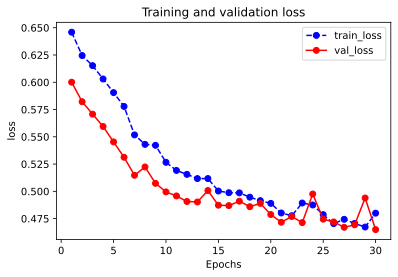

In [54]:
plot_metric(history,"loss")

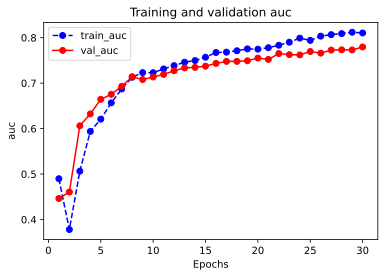

In [16]:
plot_metric(history, "auc")

In [55]:
model.evaluate(x = x_test,y = y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5342 - auc: 0.8077


[0.5342241525650024, 0.8077467679977417]

# 使用模型

In [57]:
# 预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

array([[0.8596355 ],
       [0.19167662],
       [0.95181733],
       [0.8875871 ],
       [0.88463414],
       [0.23663831],
       [0.84617376],
       [0.46467987],
       [0.96962833],
       [0.7131544 ]], dtype=float32)

In [58]:
# 预测类别
model.predict_classes(x_test[0:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

# 保存模型

可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。推荐使用后一种方式进行保存。



In [ ]:
# 保存模型结构及权重

model.save('./data/keras_model.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

In [ ]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)


In [ ]:
#保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

# TensorFlow 原生方式保存

In [ ]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)